In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import enhance_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin


In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [3]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50)))


central_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.075, 0, 50)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, -0.09, 50)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, 0.09, 50)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

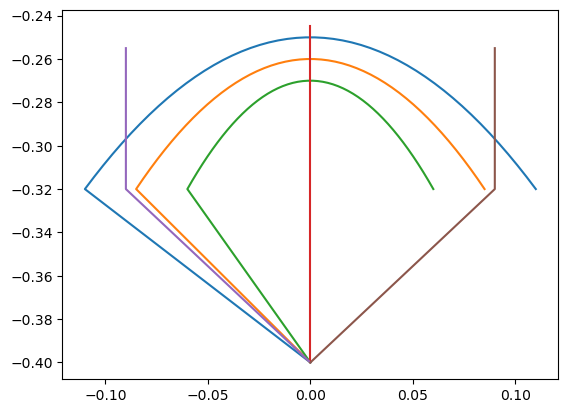

In [4]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

#plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [5]:
pin.seed(1)
topology_index = 8
gm = get_preset_by_index_with_bounds(topology_index)
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 128
n_generations = 200

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, f"first_setup\\topology_{topology_index}", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      128 |      5 |             - |             -
     2 |      256 |      3 |  0.0967553971 |         ideal
     3 |      384 |      9 |  0.4367697665 |         ideal
     4 |      512 |      7 |  0.0029875471 |         ideal
     5 |      640 |      8 |  0.1409693038 |         nadir
     6 |      768 |     14 |  0.0347975006 |             f
     7 |      896 |     22 |  0.0039904939 |         ideal
     8 |     1024 |     28 |  0.1238532088 |         ideal
     9 |     1152 |     38 |  0.0122978722 |         ideal
    10 |     1280 |     45 |  0.0094693479 |         nadir
    11 |     1408 |     35 |  0.2503573883 |         ideal
    12 |     1536 |     49 |  0.0081157536 |         ideal
    13 |     1664 |     37 |  0.0093058048 |             f
    14 |     1792 |     50 |  0.0059796257 |         ideal
    15 |     1920 |     48 |  0.0078447881 |             f
    16 |     2048 |     51 |  0.0074860051 |            

In [6]:
pin.seed(1)
sf = problem.soft_constrain
# builder = problem.builder
# crag = problem.rewards_and_trajectories.crag


counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-0.9867565 -5.7360728] [0.827423095703125, 5.765373331660001]
[-0.93226196 -5.7762396 ] [0.9386989871660868, 5.776858921077018]
[-1.12661994 -5.70986918] [1.1964436769485474, 5.325159546699638]
[-1.15757396 -5.60107973] [1.231703480084737, 5.224986026591918]
[-1.30844923 -4.90376457] [1.3044179280598958, 4.917050952792187]
[-1.39318172 -4.40831736] [1.3881738583246868, 4.4297821854319785]
[-1.27153822 -5.2665293 ] [1.268674373626709, 5.289804683007525]
[-1.26485976 -5.30532297] [1.2589650551478069, 5.3517209279062925]
[-1.31939888 -4.84042644] [1.3158955971399944, 4.865141722917083]
[-1.40920492 -4.34987257] [1.4072823524475098, 4.0567719065251735]
[-1.35764893 -4.75464337] [1.3562992811203003, 4.3962658116239135]
[-1.27289208 -5.26156211] [1.2684862613677979, 5.298821442411561]
[-1.54338749 -3.56529982] [1.5423672596613567, 3.5721542015699996]
[-1.564442   -3.43597269] [1.5649311542510986, 3.4328071151819013]
[-1.53235439 -3.59782979] [1.5316270192464192, 3.6015513848966094]
[-1.3151

0